# FitBot Conversational Model 
---
The conversational bot that helps you with your diet and anything else you need to achieve a more balanced and aware life

## Architecture
---
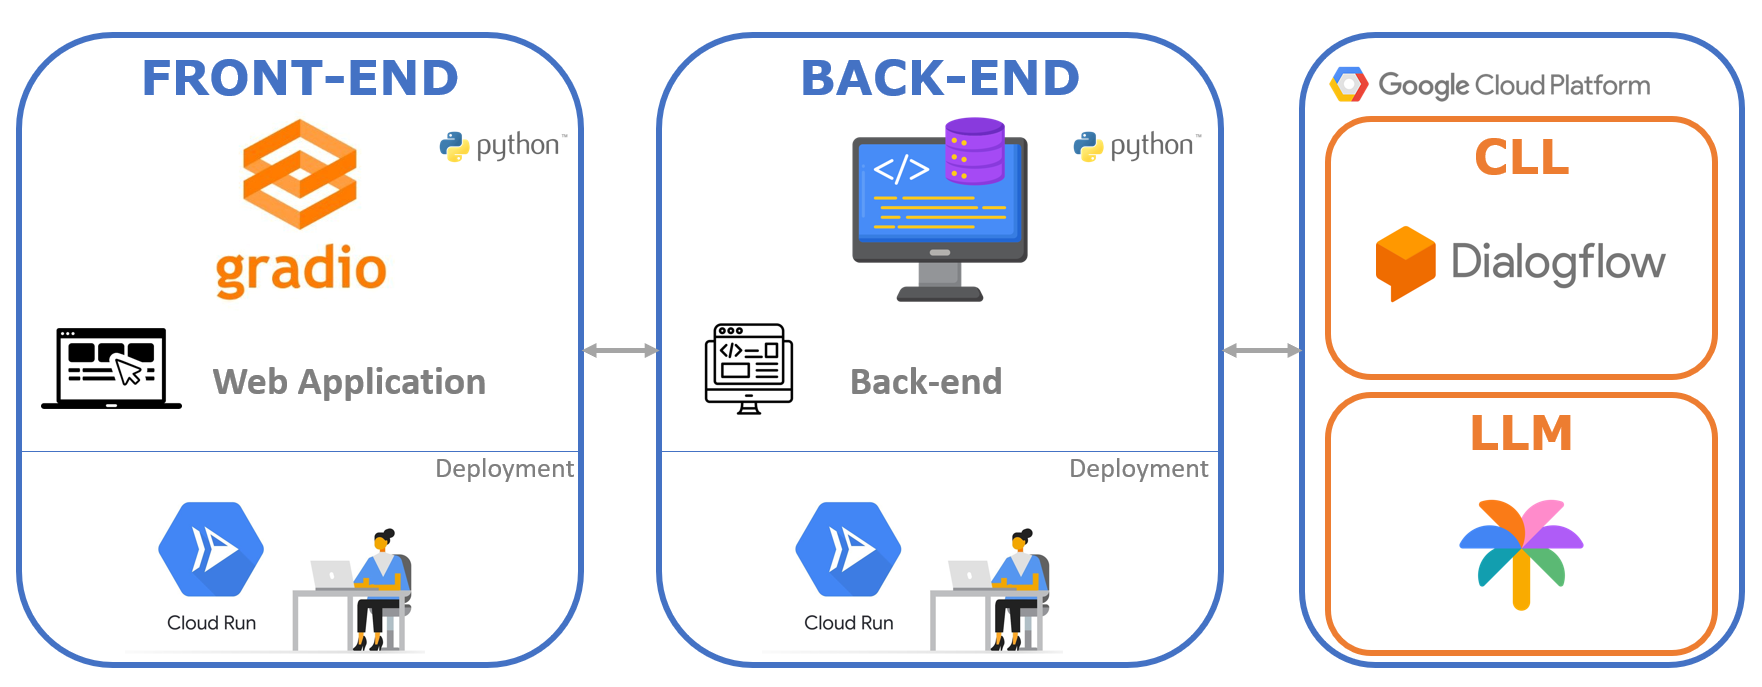

## File structure
---
The file is structured following this structure: 
1. Imports 
2. NLP Conversational Model 
    - Authentication
    - Session creation
3. Large Language Model 
    - Authentication
    - Environment set up
4. Computer Vision Model 
    - Authentication
    - Environment set up
5. Function development 
6. Web Application


## Imports
---
Import of all the libraries needed in the model


In [1]:
# Environment variables
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# NLP Conversational Model
from google.cloud import dialogflow
import uuid
from google.oauth2 import service_account
import random
import time
from PIL import Image
import numpy as np

In [3]:
# Large Language Model
from google.oauth2 import service_account
from vertexai.preview.language_models import TextGenerationModel
from google.cloud import aiplatform

In [4]:
# Computer Vision Model
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO
from IPython.display import display, Image

from roboflow import Roboflow

Ultralytics YOLOv8.0.20  Python-3.10.9 torch-2.0.1+cpu CPU
Setup complete  (8 CPUs, 7.8 GB RAM, 310.2/475.7 GB disk)


In [5]:
# Web Application
import gradio as gr

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## NLP Conversational Model 
--- 
The NLP Conversational Model has been developed using the following technologies: 
- Google Dialogflow 
- Python

### Authentication
The first step is authenticate the computer in the Google Cloud platform. Following the best practices, a service account with the least priviledge principle has been created for it and it has been used to connect to the cloud. 


In [6]:
service_account_key = os.getenv('service_account_key')
credentials = service_account.Credentials.from_service_account_file(service_account_key)

### Session Creation
A session represents a conversation between a Dialogflow agent and an end-user. You create a session at the beginning of a conversation and use it for each turn of the conversation. Once the conversation has ended, you discontinue using the session

In [7]:
session_id = uuid.uuid4().hex

# Load the variables to access the databases
project_id = os.getenv('project_id')
language_code = 'en'

# Create the session with the appropriate credentials
session_client = dialogflow.SessionsClient(credentials=credentials)

session = session_client.session_path(project_id, session_id)

## Large Language Model 
--- 
The Large Language Model connection has been developed using the following technologies: 
- Google Vertex AI
- Python

### Authentication
The first step is authenticate the computer in the Google Cloud platform. Following the best practices, a service account with the least priviledge principle has been created for it and it has been used to connect to the cloud.

In [8]:
region = os.getenv('region')
aiplatform.init(project=project_id, location=region)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = service_account_key

### Environment set up
When using vertex AI certain paramenters must be set up including most importantly the temperature and the model

In [9]:
parameters = {
    "temperature": 0.2,  # Temperature controls the degree of randomness in token selection.
    "max_output_tokens": 1024,  # Token limit determines the maximum amount of text output.
    "top_p": 0.8,  # Tokens are selected from most probable to least until the sum of their probabilities equals the top_p value.
    "top_k": 40,  # A top_k of 1 means the selected token is the most probable among all tokens.
}

model = TextGenerationModel.from_pretrained("text-bison@001")

## Computer Vision Model 
--- 
The Computer Vision Model connection has been developed using the following technologies: 
- Dialogflow
    - YoloV8
- Python

### Authentication
The first step is authenticate the computer in the Dialogflow platform. In order to do so an api_key is necessary. The key has been saved as an environment variable

In [10]:
api_key = os.getenv('roboflow_api_key')
rf = Roboflow(api_key=api_key)

### Environment Set Up
In order to connect to the right model, the model and version must be defined

In [11]:
project = rf.workspace().project("nutrition-object-detection")
model = project.version(1).model

loading Roboflow workspace...


loading Roboflow project...


## Function development
---
Now that all the models are initiated and ready to be used, the functions that will handle the exchange between them will be defined

In [12]:
# Function to request an answer to our dialogflow agent according to a text 
def dialogflow_request(text, language_code):
    text_input = dialogflow.TextInput(text=text, language_code=language_code)
    query_input = dialogflow.QueryInput(text=text_input)
    response = session_client.detect_intent(
        request={"session": session, "query_input": query_input}
    )
    response_message = str(response.query_result.fulfillment_messages[0].text.text[0])
    # If statement to connect to the LLM model in specific cases
    if "<<<llmquestion" in response_message:
        llm_response = model.predict((response_message.split("<<<llmquestion:")[1][:-3]), **parameters)
        return llm_response.text
    else:
        return response_message

In [13]:
# Function to request an answer to our Computer Vision model according to an image
def image_recognition(imagePath):
    print("Image Path:", imagePath) 
    results = model.predict(imagePath, confidence=50, overlap=50).json()
    if results['predictions'] == []:
        prediction = 'Not found'
    else:
        prediction = results['predictions'][0]['class']
    return prediction

In [15]:
# Web Application functions to allow the front-end to interact with the user
def respond(message, chat_history):
    if isinstance(message, str):
        # If the message is a string, treat it as a text input
        bot_message = dialogflow_request(message, 'en')
        chat_history.append((message, bot_message))
    elif isinstance(message, gr.inputs.File):
        # If the message is a file input, treat it as an image
        image_path = message.name
        prediction = image_recognition(image_path)
        bot_message = dialogflow_request(prediction, 'en')
        #bot_message = f"The image shows {prediction}"
        chat_history.append(((message.name,), bot_message))
    else:
        bot_message = "Invalid input"
        chat_history.append((message, bot_message))
    
    time.sleep(1)
    return "", chat_history


# Function to add text to the chat
def add_text(history, text):
    history.append((text, None))
    return history, respond(text)

# Function to add a file
def add_file(history, file):
    history.append(((file.name,), None))
    return history

## Web Application 
---
The Web Application has been developed using the following technologies: 
- Gradio
- Python

In [16]:
with gr.Blocks(css=".gradio-container {background-color: DarkSlateBlue}") as demo:
    disclaimer_agreed = gr.State(False)
    def conditions_met(newValue):
        disclaimer_agreed.value = newValue

    gr.Markdown("""
            <h1 style="text-align: center; color:white;" >FitBot</h1>
            <h4 style="text-align: center; color:white">Your personal food and health assistant</h4>
            """)

    with gr.Row():
        with gr.Column(scale=4):
            # Create a chatbot component and a model component
            chatbot = gr.Chatbot([], elem_id="chatbot", label="FitBot").style()
        with gr.Column(scale=1):
            gr.Markdown("""
            <h2 style="color:white" >Disclaimer</h2>
            <p style="color:white">The following bot is not meant following any regulatory health practice. All the information that is presented to you
            is generated from Vertex AI, the generative AI developed by Google. If you are interested in knowing more about the project and how this model
            was built, please refer to the following <a href="https://github.com/Niccoborg22/virtual-nutritionist-bot" style="color:white">Github link</a></p>
            """)

    with gr.Row():
        # Create a textbox component
        with gr.Column(scale=8):
            msg = gr.Textbox(
                show_label=False,
                placeholder="Enter text and press enter, or upload an image",
            ).style(container=False)
        with gr.Column(scale=1, min_width=0):
            # Create an upload button component to add images
            btn = gr.UploadButton("📁", file_types=["image"])

    with gr.Row(scale=0.7):
        clear_btn = gr.Button(value="🗑️  Clear")

    
    msg.submit(respond, [msg, chatbot], [msg, chatbot])
        
    # Create a message component for file uploads
    file_msg = btn.upload(add_file, [chatbot, btn], [chatbot], queue=False)
    clear_btn.click(lambda: None, None, chatbot, queue=False)

# launch the application
demo.launch()

The `style` method is deprecated. Please set these arguments in the constructor instead.
The `style` method is deprecated. Please set these arguments in the constructor instead.
You have unused kwarg parameters in Row, please remove them: {'scale': 0.7}


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "c:\Users\borga\Desktop\IE Computer Science\Semester 3\NLP Conversational Model\Final Project\myenv\lib\site-packages\gradio\routes.py", line 437, in run_predict
    output = await app.get_blocks().process_api(
  File "c:\Users\borga\Desktop\IE Computer Science\Semester 3\NLP Conversational Model\Final Project\myenv\lib\site-packages\gradio\blocks.py", line 1352, in process_api
    result = await self.call_function(
  File "c:\Users\borga\Desktop\IE Computer Science\Semester 3\NLP Conversational Model\Final Project\myenv\lib\site-packages\gradio\blocks.py", line 1077, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "c:\Users\borga\Desktop\IE Computer Science\Semester 3\NLP Conversational Model\Final Project\myenv\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "c:\Users\borga\Desktop\IE Computer Science\Semester 3\NLP Conversational Model\Fina